In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

About Dataset:

https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images?resource=download

Context
Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

Content
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

In [2]:
import tensorflow as tf

data_dir = r"C:\Users\Nandhini R\OneDrive\Desktop\Breast Cancer"
img_height = 224

img_width = 224
batch_size = 32

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5000 files belonging to 2 classes.
Using 4000 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Malignant']


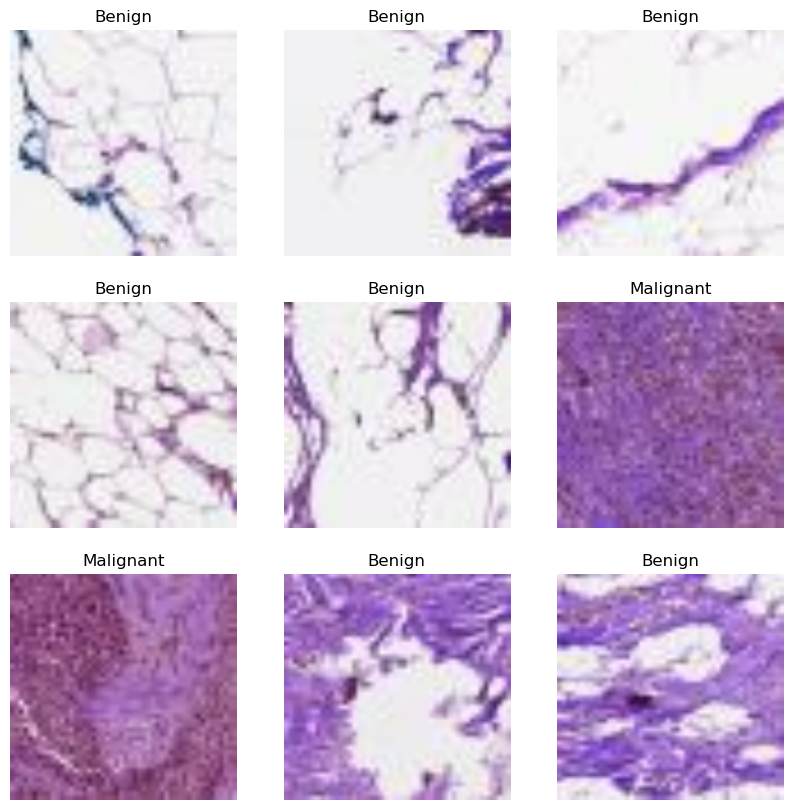

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

(32, 224, 224, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13321081 0.9933376


In [14]:
from tensorflow.keras.models import Sequential
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)       

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
125/125 [==============================] - 77s 598ms/step - loss: 0.4229 - accuracy: 0.8192 - val_loss: 0.3333 - val_accuracy: 0.8610
Epoch 2/10
125/125 [==============================] - 73s 582ms/step - loss: 0.3224 - accuracy: 0.8637 - val_loss: 0.3420 - val_accuracy: 0.8510
Epoch 3/10
125/125 [==============================] - 74s 590ms/step - loss: 0.2906 - accuracy: 0.8885 - val_loss: 0.3428 - val_accuracy: 0.8640
Epoch 4/10
125/125 [==============================] - 77s 617ms/step - loss: 0.2905 - accuracy: 0.8802 - val_loss: 0.2734 - val_accuracy: 0.8970
Epoch 5/10
125/125 [==============================] - 72s 573ms/step - loss: 0.2572 - accuracy: 0.8965 - val_loss: 0.2738 - val_accuracy: 0.8870
Epoch 6/10
125/125 [==============================] - 72s 573ms/step - loss: 0.2852 - accuracy: 0.8892 - val_loss: 0.3102 - val_accuracy: 0.8700
Epoch 7/10
125/125 [==============================] - 71s 567ms/step - loss: 0.2510 - accuracy: 0.9005 - val_loss: 0.2745 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

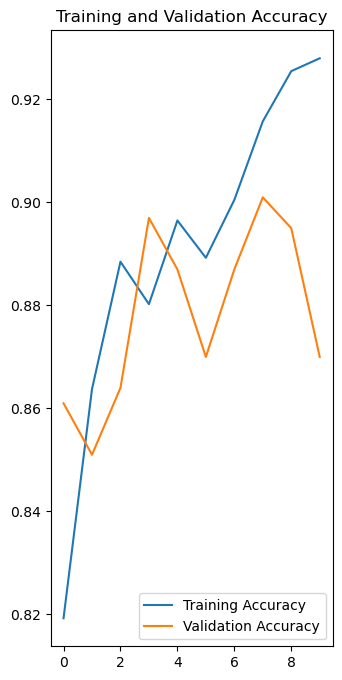

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


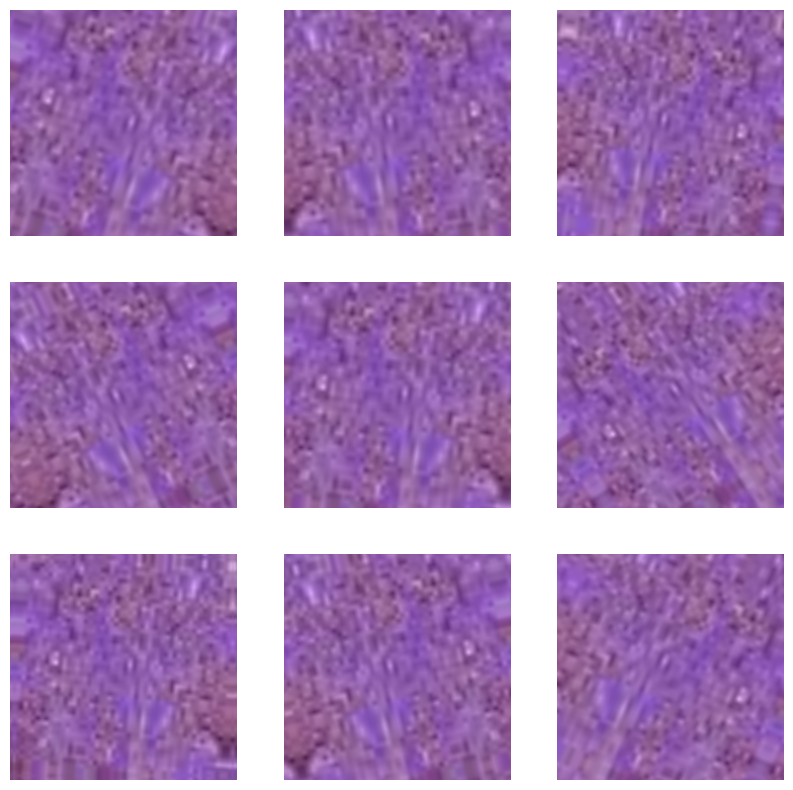

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
125/125 [==============================] - 85s 658ms/step - loss: 0.4232 - accuracy: 0.8295 - val_loss: 0.3394 - val_accuracy: 0.8730
Epoch 2/15
125/125 [==============================] - 83s 661ms/step - loss: 0.3255 - accuracy: 0.8670 - val_loss: 0.2983 - val_accuracy: 0.8830
Epoch 3/15
125/125 [==============================] - 83s 662ms/step - loss: 0.3057 - accuracy: 0.8777 - val_loss: 0.2895 - val_accuracy: 0.8950
Epoch 4/15
125/125 [==============================] - 83s 666ms/step - loss: 0.3068 - accuracy: 0.8823 - val_loss: 0.3091 - val_accuracy: 0.8690
Epoch 5/15
125/125 [==============================] - 91s 729ms/step - loss: 0.3089 - accuracy: 0.8785 - val_loss: 0.3637 - val_accuracy: 0.8220
Epoch 6/15
125/125 [==============================] - 92s 736ms/step - loss: 0.2858 - accuracy: 0.8857 - val_loss: 0.2832 - val_accuracy: 0.8820
Epoch 7/15
125/125 [==============================] - 87s 696ms/step - loss: 0.2817 - accuracy: 0.8840 - val_loss: 0.2795 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

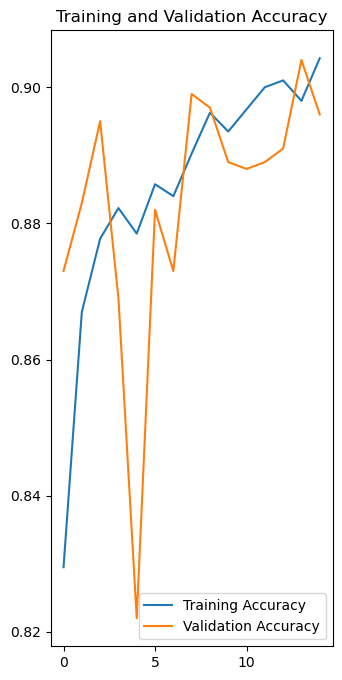

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
